1.1、提取当日日成交数据存入数据库。
1.2、提取指定小区成交数据并存入数据库。
2、从数据库提取数据。
3、获得每日成交量。
4、获得某个单价区间的成交量。
5、获得某个总价区间的成交量。
6、获得某个小区的成交信息，并将小区信息保存到csv文件中。
7、按年/月统计单价平均值。


In [ ]:
#提取当日成交数据并存入数据库
from spyder_chengjiao import spyder_chengjiao,dropduplicate_db
spyder_chengjiao()
print('开始查重...')
dropduplicate_db()

In [ ]:
#提取指定小区的成交数据并存入数据库
from spider_lianjia.spiders.chengjiao import get_chengjiao_one
from spyder_chengjiao import insert_db
g1=get_chengjiao_one().get_chengjiao('第五郡四号地')
list=[]
for i in range(0,len(g1)):
    list.append({'title':g1[i][0],'room':g1[i][3],'area':g1[i][5],'dealDate':g1[i][11],'totalPrice':g1[i][1],'unitPrice':g1[i][2],'dealCycle':g1[i][10],
    'guaPai':g1[i][9],'seller':0,'district':g1[i][7],'quyu':g1[i][6]})
insert_db(list)

In [1]:
 #需导入的模块
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import datetime
from numpy import random #经常有用
import re
import pymongo

#将pymongo数据转换成Dataframe
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["db_lianjia"]
mycol = mydb["chengjiao"]

x = list(mycol.find())
df=DataFrame(x)
#把没用的id删除掉
df=df.drop('_id',axis=1)    
df.drop_duplicates(inplace=True)
#把车位这一行删掉
df.drop(index=df[df['area']=='车位'].index,inplace=True) 
df['area']=df['area'].apply(lambda x: float(re.search("\d+(\.\d+)?",x).group()))
tofloat=lambda x:float(x)
df['unitPrice']=df['unitPrice'].apply(tofloat)
df['totalPrice']=df['totalPrice'].apply(tofloat)
df['dealDate']=pd.to_datetime(df['dealDate'])
# df['dealCycle']=df['dealCycle'].apply(lambda x: int(re.search('\d+',x).group()))#有些老的数据没有dealcycle
df['guaPai']=df['guaPai'].apply(lambda x: float(re.search("\d+(\.\d+)?",x).group()))


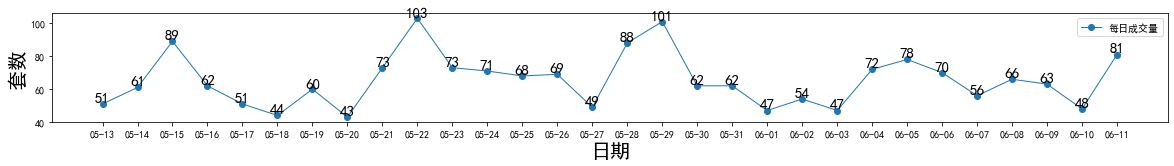

In [2]:
#获得每日成交量
df['count']=0
d=df.groupby(['dealDate']).count()['count']
d=d[-30:]

import matplotlib.pyplot as plt
plt.rcParams['font.family']=['SIMHEI']
plt.figure(figsize=(20, 2))
plt.plot(d.index,d.values,label='每日成交量',linewidth=1,marker='o')
plt.xlabel('日期',fontsize=20)
plt.ylabel('套数',fontsize=20)
plt.xticks(d.index,list(map(lambda x:x.date().strftime('%m-%d'),d.index)))
plt.legend()
for x,y in zip(d.index,d.values):
    plt.text(x, y+0.05, y, ha='center', va= 'bottom',fontsize=15)
plt.show()
 

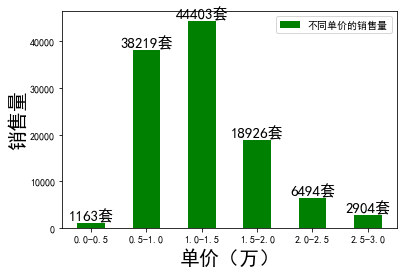

In [3]:
#获得某个单价区间的成交量
bins=[0,5000,10000,15000,20000,25000,30000]
cats=pd.cut(df['unitPrice'],bins)
X=np.arange(1,7)
Y=pd.value_counts(cats,sort=False).values
x_label=list(map(lambda x:str(x/10000)+'-'+str((x+5000)/10000),bins[:6]))
color=['red','black','peru','orchid','deepskyblue']
plt.rcParams['font.family']=['SIMHEI']
plt.bar(x=X,height=Y,align='center',width=0.5,label='不同单价的销售量',color='g')
plt.xticks(X,x_label)
plt.xlabel('单价（万）',fontsize=20)
plt.ylabel('销售量',fontsize=20)
plt.legend(loc='best')
for x,y in zip(X,Y):
    s=str(y)+'套'
    plt.text(x, y+0.05, s, ha='center', va= 'bottom',fontsize=15)
plt.show()

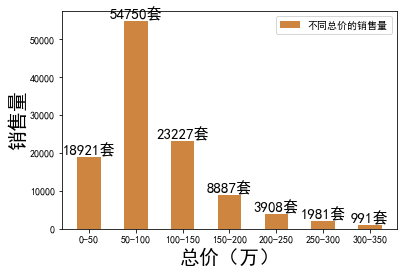

In [4]:
#获得某个总价区间的成交量
bins=[0,50,100,150,200,250,300,350]
cats=pd.cut(df['totalPrice'],bins=bins)
X=np.arange(1,8)
Y=pd.value_counts(cats,sort=False).values
x_label=list(map(lambda x:str(x)+'-'+str((x+50)),bins[:7]))
color=['red','black','peru','orchid','deepskyblue']
plt.rcParams['font.family']=['SIMHEI']
plt.bar(x=X,height=Y,align='center',width=0.5,label='不同总价的销售量',color='peru')
plt.xticks(X,x_label)
plt.xlabel('总价（万）',fontsize=20)
plt.ylabel('销售量',fontsize=20)
plt.legend(loc='best')
for x,y in zip(X,Y):
    s=str(y)+'套'
    plt.text(x, y+0.05, s, ha='center', va= 'bottom',fontsize=15)
plt.show()

In [5]:
#获得某个小区的成交信息
try:
    df=df.drop(columns=['count'])
    dwj=df[df['title'].apply(lambda x:'第五郡' in x and '公寓' not in x)]
    t=dwj.sort_values(['dealDate'])
    t.describe().round(0).unstack()
except KeyError as e:
    pass
dwj.sort_values(by=['dealDate'])
#保存到csv文件
dwj.to_csv('data/data.csv',encoding='gbk')

In [ ]:
#按年/月计算平均单价
#按年计算平均单价
df['year']=df['dealDate'].apply(lambda x:x.year)
df['month']=df['dealDate'].apply(lambda x:x.month)
g1=df['unitPrice'].groupby(df['year']).mean()
#按月计算平均单价
g2=df['unitPrice'].groupby(df['month']).mean()
#按年月计算平均单价
g3=df['unitPrice'].groupby([df['year'],df['month']]).mean()
print(g1)

In [ ]:
#按年/月计算平均总价
#按年计算平均总价
df['year']=df['dealDate'].apply(lambda x:x.year)
df['month']=df['dealDate'].apply(lambda x:x.month)
z1=df['totalPrice'].groupby(df['year']).mean()
#按月计算平均总价
z2=df['totalPrice'].groupby(df['month']).mean()
#按年月计算平均总价
z3=df['totalPrice'].groupby([df['year'],df['month']]).mean()
print(z1)